<h1><center>Correlation on Ising Model</center></h1>



### $$ r(i,j) = \frac{\left \langle x_i(t) x_j(t) \right \rangle - \left \langle x_i(t) \right \rangle \left \langle x_j(t) \right \rangle}{\sigma[x_i(t)]\sigma[x_j(t)]} $$

#### where

### $$ \sigma^2[x_l(t)] = \left \langle x^2_l(t) \right \rangle - \left \langle x_l(t) \right \rangle^2 $$

### $$\text{Where $x_l(t)$ is the the BOLD signal of voxel $l$ if we are studying the brain data}$$
### $$\text{or the spin time series (of site $l$) from the Ising Model.}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,prange
import nbimporter
from Ising_Model_MCMC import initial_state, temporalseries

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
@jit(nopython=True, fastmath=True, nogil=True)
def corr_net(temporal_series):
    
    steps = len(temporal_series)
    spins = len(temporal_series[0])**2
    
    temporal_series_linear = temporal_series.reshape((steps*spins ))
    
    corr_array = np.array([0.0])
    xi = np.zeros(steps)
    xj = np.zeros(steps)
    for i in range(spins):
        corr = np.zeros(spins - (i+1))
        for j in range(i+1,spins):
            for n in range(steps):
                xi[n] = temporal_series_linear[i + n*spins]
                xj[n] = temporal_series_linear[j + n*spins]
            corr[j - (i+1)] = float(np.corrcoef(xi,xj)[0,1])
        corr_array = np.concatenate((corr_array,corr))
        
    return corr_array

### When the lattice is really big, we need a lot of memory to calculate all the correlation.

For example, if the lattice is n=200 we have (200*199/2) correlations to calculate.

### So we can average near sites to get a smaller lattice for all the fluctuations (time).

In [3]:
def average_blocks(model, block_size):
    time_series_size = len(model[0][:,0,0]) 
    avg_model = np.zeros((time_series_size,int(len(model[0][1])/block_size),int(len(model[0][1])/block_size)))

    for t in range(time_series_size):
        for i in range(0,(len(model[0][0]) - block_size + 1),block_size):
            for j in range(0, (len(model[0][0]) - block_size + 1),block_size):
                l_0 = block_size
                avg_model[t][i//block_size, j//block_size] = np.mean(model[0][t][i:(i+l_0),j:(j+l_0)])
    return avg_model

In [4]:
J = 1     # J
n = 200    # Lattice size
T = 2.3 # Temperature
iterations = (n*n)**2    # Iterations to thermal equilibrium 
fluctuations = 2000 #2000      # Quantity of fluctuations
iterations_fluc = n*n  # Iterations in one fluctuation
config = initial_state(n, "random")
model = temporalseries(T, config, iterations, iterations_fluc, fluctuations, J, n)

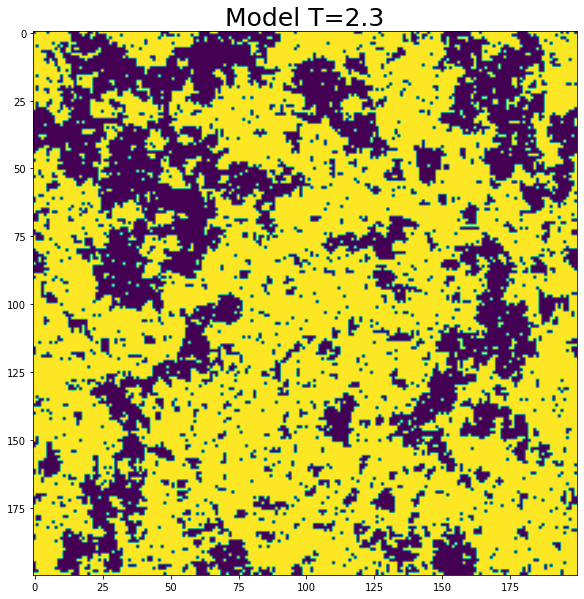

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(model[0][0,:,:], 'viridis')
plt.title("Model T={}".format(T), fontsize=25)
#plt.savefig("Avg_matri_T{}.png".format(T))
plt.show()

In [6]:
avg_model = average_blocks(model,20)

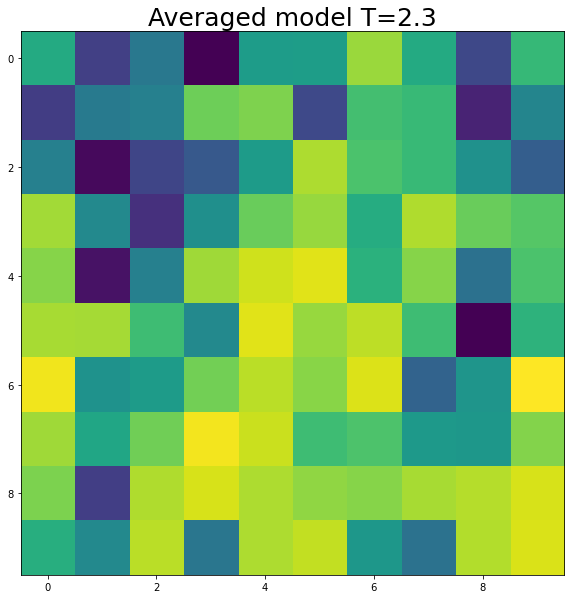

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(avg_model[0], 'viridis')
plt.title("Averaged model T={}".format(T), fontsize=25)
#plt.savefig("Avg_matri_T{}.png".format(T))
plt.show()

## Calculating the pearson's correlation between all the sites

In [8]:
corr = corr_net(avg_model)

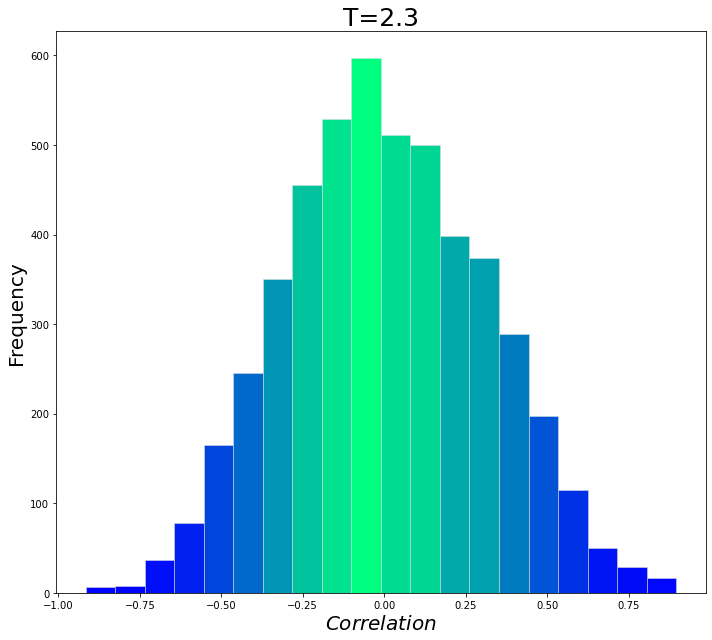

In [9]:
plt.figure(figsize=(10,9))
bins = 20
n, bins, patches = plt.hist(corr,bins=bins, facecolor='#2ab0ff',edgecolor='#e0e0e0',linewidth=0.5)

n = n.astype('int') # it MUST be integer

# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.winter(n[i]/max(n)))


plt.title("T=2.3",fontsize=25)
plt.xlabel(r"$Correlation $")
plt.ylabel("Frequency")
plt.tight_layout()

# Correlation Matrix

#### To see the spatial patterns of the correlations in the lattice, it's useful to use the correlation matrix

In [10]:
def correlation_matrix(avg_model, corr):
    size = len(avg_model[0])**2
    corr_matrix = np.zeros((size,size))
    cont = 0

    for i in range(size):
        for j in range(i, size):
            if i == j:
                corr_matrix[i,j] = float('nan')


            else:
                corr_matrix[i,j] = corr[cont]
                corr_matrix[j,i] = corr[cont]
                cont += 1 
    return corr_matrix

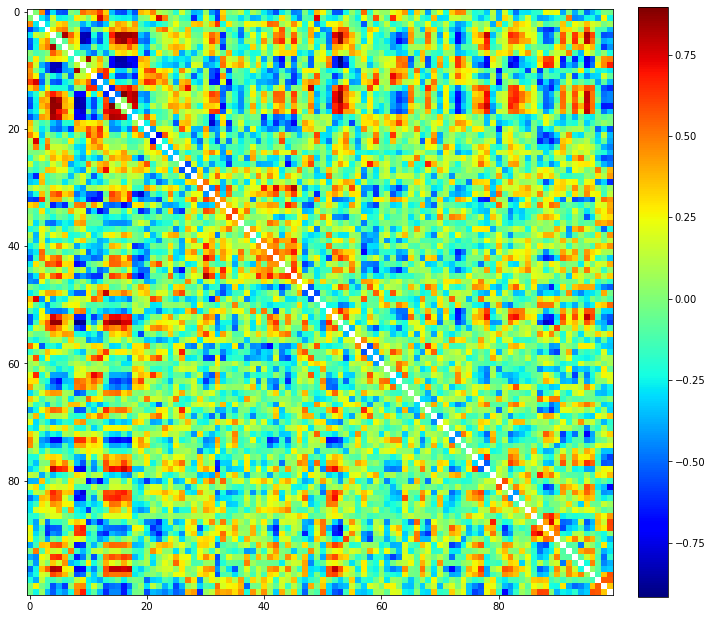

In [11]:
plt.figure(figsize=(10,10))
corr_matrix = correlation_matrix(avg_model,corr)
im= plt.imshow(corr_matrix, 'jet')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.tight_layout()
#plt.savefig("corr_matrix{}.png".format(T))

#### From econometrics articles we know that autocorrelated time series can generate spurious correlations. Hence, we can evaluate the similarity with other metrics

## Dynamic Time Waping (DTW)

In [12]:
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



<Figure size 4500x4500 with 0 Axes>

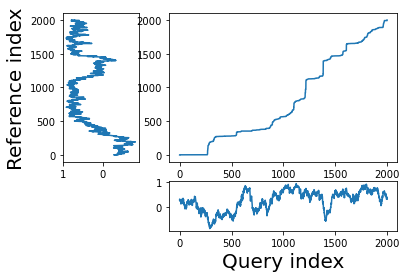

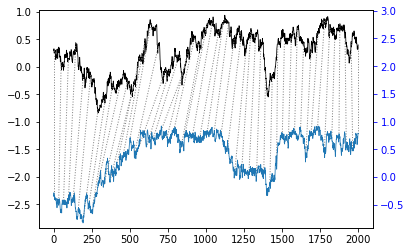

<AxesSubplot:>

In [13]:
alignment = dtw(avg_model[:,0,0], avg_model[:,0,1], keep_internals=True)


plt.figure(figsize=(15,15), dpi=300)
## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(avg_model[:,0,0] , avg_model[:,0,1], keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2,linewidth=0.8)



In [21]:
def dtw_net(temporal_series):
    
    steps = len(temporal_series)
    spins = int(len(temporal_series[0])**2)
    dtw_array = np.zeros(int(spins*(spins-1)/2))
    
    temporal_series_linear = temporal_series.reshape((steps,spins))
    cont = 0
    

    for i in range(spins):
        for j in range(i+1,spins):
            xi = np.zeros(steps)
            xj = np.zeros(steps)
            
            alignment = dtw(temporal_series_linear[:,i], temporal_series_linear[:,j], keep_internals=True)
            dtw_array[cont] = alignment.normalizedDistance




            cont += 1
    return dtw_array

In [22]:
dtw_array = dtw_net(avg_model)

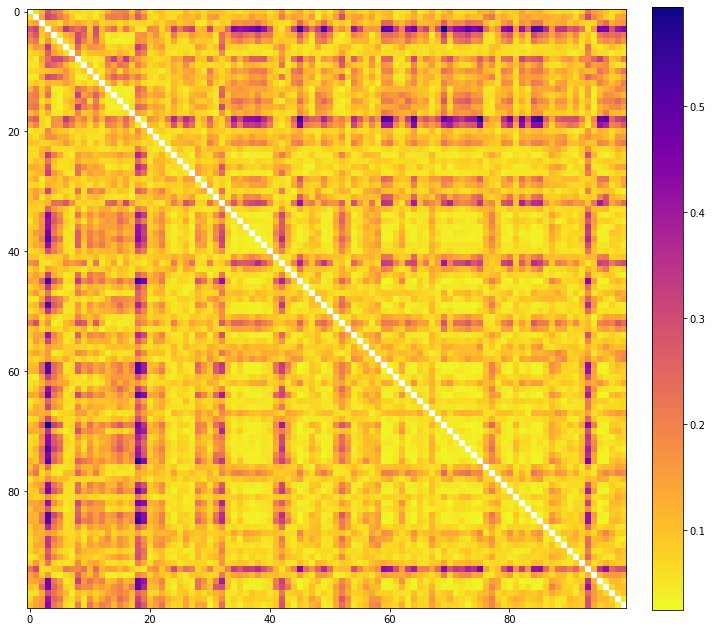

In [23]:
plt.figure(figsize=(10,10))
corr_matrix = correlation_matrix(avg_model,dtw_array)
im= plt.imshow(corr_matrix, 'plasma_r')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.tight_layout()
#plt.savefig("corr_matrix{}.png".format(T))